In [1]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from PIL import Image, ImageEnhance
import random
from tqdm.auto import tqdm
import gdown
import shutil
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import yaml
try:
    with open ("../config.yaml", 'r') as file:
        config = yaml.safe_load(file)
except Exception as e:
    print('Error reading the config file')
import sys

# ML Models
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import load_img

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

# Models creation notebook

Please run the following cell to download and create database via python script.

In [ ]:
!python ../data.py

## Setting the paths to the images: creating the dataset

- Create 2 lists for each set: one with the path to the images, another with the label for each of those images.

In [4]:
#Training
train_dir = config['data']+'Training/'
test_dir = config['data']+'Testing/'

train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    for image in os.listdir(train_dir+label):
        train_paths.append(train_dir+label+'/'+image)
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)


#Testing
test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    for image in os.listdir(test_dir+label):
        test_paths.append(test_dir+label+'/'+image)
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

## Image augmentation

- First function enhances brightness and contrast for each of the images with a random value between 0.8 and 1.2
- Second function returns an array of the images (after using the first function to enhance them).

In [5]:
def image_prep(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8,1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8,1.2))
    image = np.array(image)/255.0
    return image

def open_images(paths, pic_size=128):
    images = []
    for path in paths:
        image = load_img(path, target_size=(pic_size,pic_size))
        image = image_prep(image)
        images.append(image)
    return np.array(images)

Checking some of the pictures with matplotlib after applying the functions above

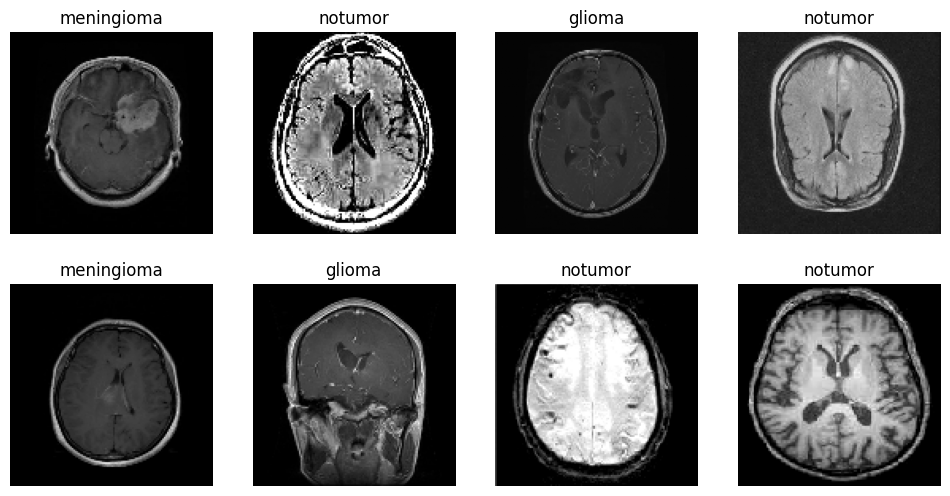

In [6]:
images = open_images(train_paths[50:59])
labels = train_labels[50:59]
fig = plt.figure(figsize=(12, 6))
for x in range(1, 9):
    fig.add_subplot(2, 4, x)
    plt.axis('off')
    plt.title(labels[x])
    plt.imshow(images[x])
plt.rcParams.update({'font.size': 12})
plt.show()

## Label encoding and data generator

- First function takes care of appending the image lable to the encode list.
- Second function takes care of appending the image lable to the decode list (to be used later).
- Third function generates the data for the model: yield is used to free up memory once the batch of images and labels is fed to it. First sets the paths, then uses the image augmentation function we defined before and encodes the image labels.

In [7]:
unique_labels = os.listdir(train_dir)

def encode_label(labels):
    encoded = []
    for x in labels:
        encoded.append(unique_labels.index(x))
    return np.array(encoded)

def decode_label(labels):
    decoded = []
    for x in labels:
        decoded.append(unique_labels[x])
    return np.array(decoded)

def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for x in range(0, len(paths), batch_size):
            batch_paths = paths[x:x+batch_size]
            batch_images = open_images(batch_paths)
            batch_labels = labels[x:x+batch_size]
            batch_labels = encode_label(batch_labels)
            yield batch_images, batch_labels

# Sequential model - from scratch

In [8]:
bts = Sequential(name='Brain_Tumor_Scanner')

# Layer 1
bts.add(Conv2D(64,(7,7), input_shape=(128, 128, 3), padding='same', activation='relu'))
bts.add(MaxPooling2D(pool_size=(2,2)))

# Layer 2
bts.add(Conv2D(128,(7,7), padding='same', activation='relu'))
bts.add(MaxPooling2D(pool_size=(2,2)))

# Layer 3
bts.add(Conv2D(128,(7,7), padding='same', activation='relu'))
bts.add(MaxPooling2D(pool_size=(2,2)))

# Layer 4
bts.add(Conv2D(256,(7,7), padding='same', activation='relu'))
bts.add(MaxPooling2D(pool_size=(2,2)))

# Layer 5
bts.add(Conv2D(256,(7,7), padding='same', activation='relu'))
bts.add(MaxPooling2D(pool_size=(2,2)))

# Layer 6
bts.add(Conv2D(256,(7,7), padding='same', activation='relu'))
bts.add(MaxPooling2D(pool_size=(2,2)))


# Connect layers
bts.add(Flatten())
bts.add(Dropout(0.3))
bts.add(Dense(128, activation='relu'))
bts.add(Dropout(0.2))
bts.add(Dense(len(unique_labels), activation='softmax'))


bts.compile(optimizer=Adam(learning_rate=0.0001),
             loss='sparse_categorical_crossentropy',
             metrics=['sparse_categorical_accuracy'])

bts.summary()

Model: "Brain_Tumor_Scanner"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      9472      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       802944    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 12

In [9]:
batch_size = 20
steps = int(len(train_paths)/batch_size)
epochs = 12
bts_mcp = ModelCheckpoint(filepath = config['models']+'bts_weights.h5', monitor = 'sparse_categorical_accuracy', 
                      save_best_only = True, verbose = 2)
bts_es = EarlyStopping(monitor = 'loss', min_delta = 1e-10, patience = 3, verbose = 1)
bts_rlr = ReduceLROnPlateau(monitor = 'loss', factor = 0.2, patience = 2, verbose = 1)


bts_history = bts.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps, callbacks=[bts_mcp, bts_es, bts_rlr])

Epoch 1/12
285/285 [==============================] - ETA: 0s - loss: 0.8856 - sparse_categorical_accuracy: 0.5988
Epoch 1: sparse_categorical_accuracy improved from -inf to 0.59877, saving model to ../models/bts_weights.h5
285/285 [==============================] - 438s 2s/step - loss: 0.8856 - sparse_categorical_accuracy: 0.5988 - lr: 1.0000e-04
Epoch 2/12
285/285 [==============================] - ETA: 0s - loss: 0.5333 - sparse_categorical_accuracy: 0.7846
Epoch 2: sparse_categorical_accuracy improved from 0.59877 to 0.78461, saving model to ../models/bts_weights.h5
285/285 [==============================] - 444s 2s/step - loss: 0.5333 - sparse_categorical_accuracy: 0.7846 - lr: 1.0000e-04
Epoch 3/12
285/285 [==============================] - ETA: 0s - loss: 0.3948 - sparse_categorical_accuracy: 0.8482
Epoch 3: sparse_categorical_accuracy improved from 0.78461 to 0.84821, saving model to ../models/bts_weights.h5
285/285 [==============================] - 441s 2s/step - loss: 0.3948

In [10]:
bts.save(config['models']+'bts.model')

INFO:tensorflow:Assets written to: ../models/bts.model/assets


INFO:tensorflow:Assets written to: ../models/bts.model/assets


### Visualization of the model training

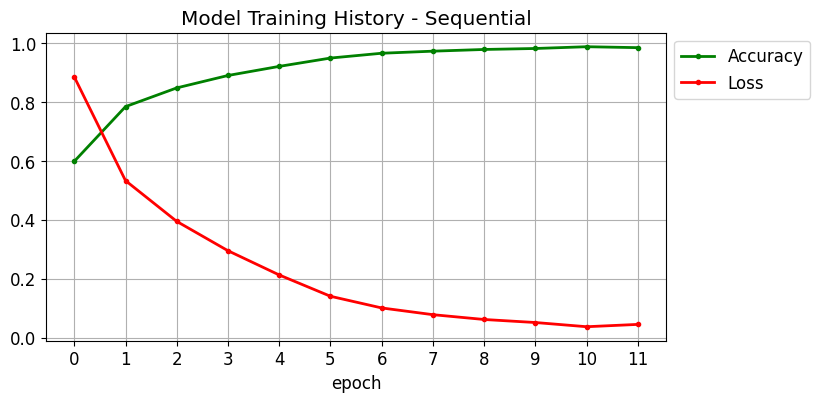

In [11]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(bts_history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(bts_history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History - Sequential')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

## Generating the validation set

In [12]:
batch_size = 32
steps = int(len(test_paths)/batch_size)
y_pred_bts = []
y_true_bts = []
for x,y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
    pred = bts.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in decode_label(pred):
        y_pred_bts.append(i)
    for i in decode_label(y):
        y_true_bts.append(i)

  0%|          | 0/40 [00:00<?, ?it/s]

1/1 [==============================] - 1s 518ms/step


## Model performance: Classification Report and Confusion Matrix

In [13]:
print(classification_report(y_true_bts, y_pred_bts))

              precision    recall  f1-score   support

      glioma       0.98      0.92      0.95       300
  meningioma       0.94      0.95      0.94       306
     notumor       0.98      1.00      0.99       405
   pituitary       0.97      1.00      0.99       300

    accuracy                           0.97      1311
   macro avg       0.97      0.97      0.97      1311
weighted avg       0.97      0.97      0.97      1311



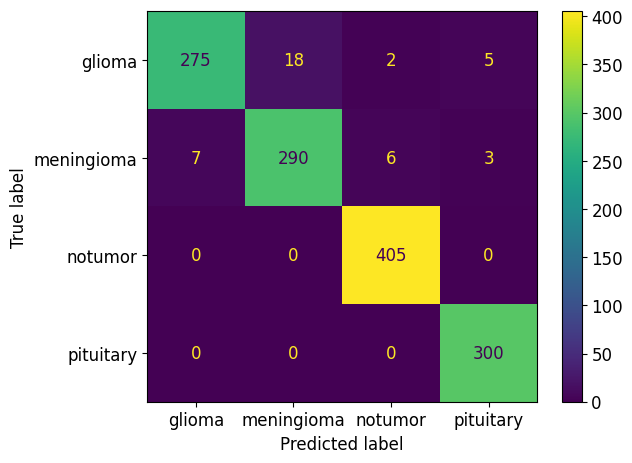

In [14]:
m_labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Confusion matrix
cm_bts = confusion_matrix(y_true_bts, y_pred_bts)
display_cm_bts = ConfusionMatrixDisplay(cm_bts, display_labels=m_labels)
display_cm_bts.plot()
plt.tight_layout()

plt.savefig(config['pics']+'confusion_matrix_bts.png', bbox_inches='tight')

Our model has a really good performance. We will check another model created from transfer learning.

# Transfer Learning model: VGG16

In [15]:
#Import VGG16 - Very Deep Convolutional Networks for Large-Scale Image Recognition
base_model = VGG16(input_shape=(128,128,3), include_top=False, weights='imagenet')

# Set all layers to non-trainable
for layer in base_model.layers:
    layer.trainable = False

# Set the last vgg16 block to trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

trl = Sequential(name='Brain_Tumor_Scanner_TRL')
trl.add(Input(shape=(128,128,3)))
trl.add(base_model)
trl.add(Flatten())
trl.add(Dropout(0.3))
trl.add(Dense(128, activation='relu'))
trl.add(Dropout(0.2))
trl.add(Dense(len(unique_labels), activation='softmax'))

trl.compile(optimizer=Adam(learning_rate=0.0001),
             loss='sparse_categorical_crossentropy',
             metrics=['sparse_categorical_accuracy'])

base_model.summary()

58889256/58889256 [==============================] - 4s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                              

In [16]:
trl.summary()

Model: "Brain_Tumor_Scanner_TRL"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dropout_2 (Dropout)         (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               1048704   
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 4)                 516       
                                                                 
Total params: 15,763,908
Trainable params: 

In [17]:
batch_size = 20
steps = int(len(train_paths)/batch_size)
epochs = 12
trl_mcp = ModelCheckpoint(filepath = config['models']+'trl_weights.h5', monitor = 'sparse_categorical_accuracy', 
                      save_best_only = True, verbose = 2)
trl_es = EarlyStopping(monitor = 'loss', min_delta = 1e-10, patience = 3, verbose = 1)
trl_rlr = ReduceLROnPlateau(monitor = 'loss', factor = 0.2, patience = 2, verbose = 1)


trl_history = trl.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps, callbacks=[trl_mcp, trl_es, trl_rlr])

Epoch 1/12
285/285 [==============================] - ETA: 0s - loss: 0.4622 - sparse_categorical_accuracy: 0.8288
Epoch 1: sparse_categorical_accuracy improved from -inf to 0.82877, saving model to ../models/trl_weights.h5
285/285 [==============================] - 194s 679ms/step - loss: 0.4622 - sparse_categorical_accuracy: 0.8288 - lr: 1.0000e-04
Epoch 2/12
285/285 [==============================] - ETA: 0s - loss: 0.2385 - sparse_categorical_accuracy: 0.9115
Epoch 2: sparse_categorical_accuracy improved from 0.82877 to 0.91145, saving model to ../models/trl_weights.h5
285/285 [==============================] - 196s 690ms/step - loss: 0.2385 - sparse_categorical_accuracy: 0.9115 - lr: 1.0000e-04
Epoch 3/12
285/285 [==============================] - ETA: 0s - loss: 0.1703 - sparse_categorical_accuracy: 0.9359
Epoch 3: sparse_categorical_accuracy improved from 0.91145 to 0.93587, saving model to ../models/trl_weights.h5
285/285 [==============================] - 198s 696ms/step - los

In [18]:
trl.save(config['models']+'trl.model')

INFO:tensorflow:Assets written to: ../models/trl.model/assets


INFO:tensorflow:Assets written to: ../models/trl.model/assets


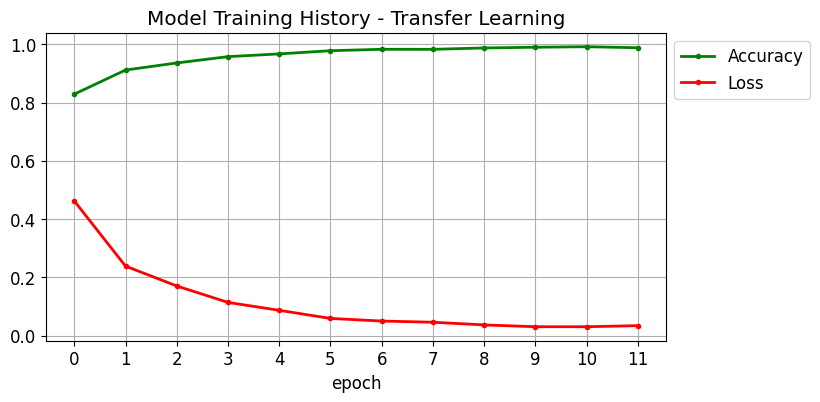

In [19]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(trl_history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(trl_history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History - Transfer Learning')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [20]:
batch_size = 32
steps = int(len(test_paths)/batch_size)
y_pred_trl = []
y_true_trl = []
for x,y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
    pred = trl.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in decode_label(pred):
        y_pred_trl.append(i)
    for i in decode_label(y):
        y_true_trl.append(i)

  0%|          | 0/40 [00:00<?, ?it/s]

1/1 [==============================] - 1s 834ms/step


## Model evaluation

In [21]:
print(classification_report(y_true_trl, y_pred_trl))

              precision    recall  f1-score   support

      glioma       0.98      0.91      0.94       300
  meningioma       0.87      0.98      0.92       306
     notumor       1.00      1.00      1.00       405
   pituitary       1.00      0.94      0.97       300

    accuracy                           0.96      1311
   macro avg       0.96      0.96      0.96      1311
weighted avg       0.96      0.96      0.96      1311



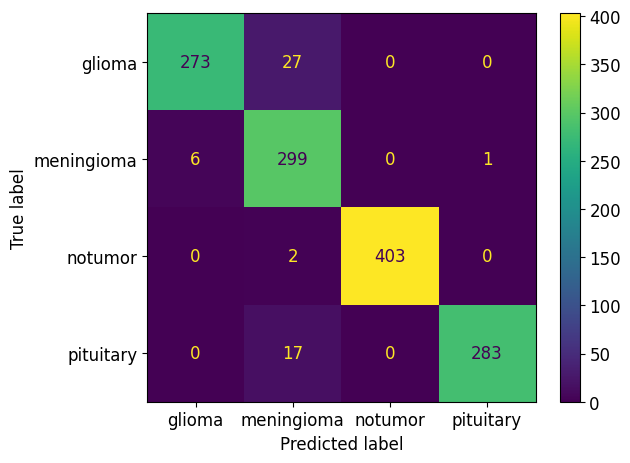

In [22]:
# Confusion matrix
cm_trl = confusion_matrix(y_true_trl, y_pred_trl)
display_cm_trl = ConfusionMatrixDisplay(cm_trl, display_labels=m_labels)
display_cm_trl.plot()
plt.tight_layout()

plt.savefig(config['pics']+'confusion_matrix_trl.png', bbox_inches='tight')

#

# Predictions

In [28]:
unique_labels

['glioma', 'notumor', 'pituitary', 'meningioma']

In [35]:
def conclusion(number):
    if number==0:
        return 'Tumor - Glioma'
    elif number ==3:
        return 'Tumor - Meningioma'
    elif number == 1:
        return 'Not a tumor'
    elif number == 2:
        return 'Tumor - pituitary'
    else:
        return 'Sorry, not clear'

def diagnosis(image, model):
    img = Image.open(image)
    x = np.array(img.resize((128,128)))
    x = x.reshape(1,128,128,3)
    res = model.predict_on_batch(x)
    classification = np.where(res == np.amax(res))[1][0]
    imshow(img)
    print(conclusion(classification))

In [36]:
image = config['data']+'Testing/notumor/Te-no_0052.jpg'

In [38]:
image = config['data']+'Testing/meningioma/Te-me_0015.jpg'

Tumor - Meningioma
Tumor - Meningioma


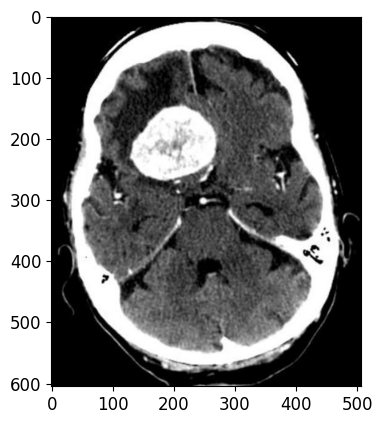

In [39]:
diagnosis(image, bts)
diagnosis(image, trl)

In [40]:
image = config['pics']+'diagnose/pituitary1.jpg'

Tumor - pituitary
Tumor - Meningioma


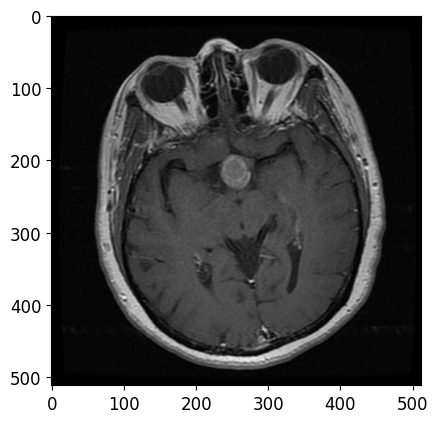

In [41]:
diagnosis(image, bts)
diagnosis(image, trl)

In [42]:
image = config['data']+'Testing/glioma/Te-gl_0036.jpg'

Tumor - Meningioma
Tumor - Glioma


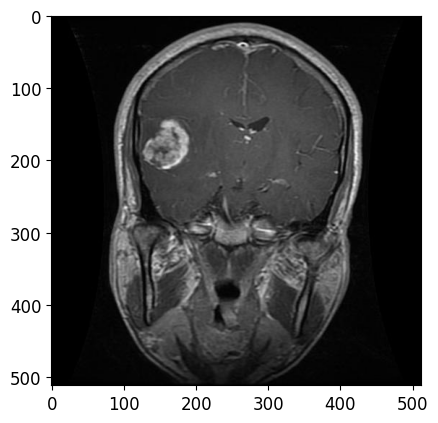

In [43]:
diagnosis(image, bts)
diagnosis(image, trl)